#**SETUP DAN INSTALASI**

In [ ]:
!pip install facenet-pytorch timm
!pip install pillow-heif pyheifd

In [2]:
import os
import shutil
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from facenet_pytorch import MTCNN
from PIL import Image, ImageOps, ImageFile
from tqdm.notebook import tqdm
from google.colab import drive
import math

In [ ]:
import pillow_heif
import pyheif

#**KONFIGURASI**

In [3]:
ZIP_FILE_PATH = '/content/drive/MyDrive/Train.zip'
RAW_DATA_DIR = '/content/dataset_mentah'
PROCESSED_DATA_DIR = '/content/dataset_wajah_crop'
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

Menggunakan device: cuda


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**EKSTRAKSI ZIP**

In [8]:
# Bersihkan folder lama
if os.path.exists(RAW_DATA_DIR): shutil.rmtree(RAW_DATA_DIR)
if os.path.exists(PROCESSED_DATA_DIR): shutil.rmtree(PROCESSED_DATA_DIR)
os.makedirs(PROCESSED_DATA_DIR)

# Ekstrak Zip
if os.path.exists(ZIP_FILE_PATH):
    print(f"   Mengekstrak: {ZIP_FILE_PATH}")
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
        zip_ref.extractall(RAW_DATA_DIR)
else:
    raise FileNotFoundError("File Zip tidak ditemukan di Google Drive! Cek path-nya.")

# Hapus Sampah MacOS (__MACOSX)
macosx = os.path.join(RAW_DATA_DIR, '__MACOSX')
if os.path.exists(macosx):
    shutil.rmtree(macosx)
    print("Sampah '__MACOSX' dihapus.")

# Cari Folder Sumber (Auto-Detect)
SOURCE_DIR = RAW_DATA_DIR
if 'Train' in os.listdir(RAW_DATA_DIR):
    SOURCE_DIR = os.path.join(RAW_DATA_DIR, 'Train')
elif 'train' in os.listdir(RAW_DATA_DIR):
    SOURCE_DIR = os.path.join(RAW_DATA_DIR, 'train')
subdirs = [d for d in os.listdir(SOURCE_DIR) if os.path.isdir(os.path.join(SOURCE_DIR, d))]
if len(subdirs) == 1:
    SOURCE_DIR = os.path.join(SOURCE_DIR, subdirs[0])

macosx_inner = os.path.join(SOURCE_DIR, '__MACOSX')
if os.path.exists(macosx_inner): shutil.rmtree(macosx_inner)

print(f" Folder sumber gambar akhir: {SOURCE_DIR}")

   Mengekstrak: /content/drive/MyDrive/Train.zip
Sampah '__MACOSX' dihapus.
 Folder sumber gambar akhir: /content/dataset_mentah/Train


In [9]:
import glob

print("\n--- Analisis Struktur Data ---")
subfolders = [
    d for d in os.listdir(SOURCE_DIR)
    if os.path.isdir(os.path.join(SOURCE_DIR, d)) and d != '__MACOSX'
]
num_folders = len(subfolders)

# 2. Hitung Total Gambar
IMAGE_EXTENSIONS = [
    # Format Umum
    '*.jpg', '*.jpeg', '*.png', '*.gif', '*.bmp',

    # Tambahan yang Anda minta
    '*.webp', '*.heic',

    # Format Lain yang Mungkin
    '*.tiff', '*.tif', '*.ico',

    # Varian Huruf Kapital untuk Case Sensitivity
    '*.JPG', '*.JPEG', '*.PNG', '*.WEBP', '*.HEIC', '*.TIF',
]
total_image_count = 0

# Iterasi melalui setiap ekstensi dan hitung file secara rekursif
for ext in IMAGE_EXTENSIONS:
    # Mencari secara rekursif (**) di semua sub-direktori
    search_path = os.path.join(SOURCE_DIR, '**', ext)
    files = glob.glob(search_path, recursive=True)
    total_image_count += len(files)

# 3. Tampilkan Hasil
print(f"Folder Sumber Akhir: **{SOURCE_DIR}**")
print(f"Jumlah Sub-Folder (Kelas): **{num_folders}**")
print(f"Total Gambar Ditemukan: **{total_image_count}**")


--- Analisis Struktur Data ---
Folder Sumber Akhir: **/content/dataset_mentah/Train**
Jumlah Sub-Folder (Kelas): **70**
Total Gambar Ditemukan: **284**


#**EKSTRAK DATA**

In [6]:
ZIP_CROP_PATH = '/content/drive/MyDrive/Backup_Project_ViT/dataset_wajah_crop.zip'

import zipfile
import os
from PIL import ImageFile

# --- VARIABEL DARI KODE ANDA ---
ZIP_CROP_PATH = '/content/drive/MyDrive/Backup_Project_ViT/dataset_wajah_crop.zip'
PROCESSED_DATA_DIR = '/content/dataset_wajah_crop'
ImageFile.LOAD_TRUNCATED_IMAGES = True

# --- EKSTRAKSI ZIP ---
print("--- Mulai Proses Ekstraksi Dataset ---")
print(f"File ZIP Sumber: {ZIP_CROP_PATH}")
print(f"Folder Tujuan: {PROCESSED_DATA_DIR}")

# 1. Pastikan folder tujuan ada
if not os.path.exists(PROCESSED_DATA_DIR):
    os.makedirs(PROCESSED_DATA_DIR)
    print(f"Folder tujuan '{PROCESSED_DATA_DIR}' berhasil dibuat.")
else:
    print(f"Folder tujuan '{PROCESSED_DATA_DIR}' sudah ada.")


# 2. Ekstrak file ZIP
try:
    with zipfile.ZipFile(ZIP_CROP_PATH, 'r') as zip_ref:
        zip_ref.extractall(PROCESSED_DATA_DIR)

    print("\n Ekstraksi selesai! File dataset crop berhasil disimpan.")

    # Verifikasi isi folder
    print(f"Isi folder {PROCESSED_DATA_DIR} (5 item pertama):")
    print(os.listdir(PROCESSED_DATA_DIR)[:5])

except FileNotFoundError:
    print(f"\n ERROR: File ZIP tidak ditemukan di {ZIP_CROP_PATH}. Pastikan path sudah benar.")
except zipfile.BadZipFile:
    print("\n ERROR: File ZIP rusak atau tidak valid.")
except Exception as e:
    print(f"\n Terjadi kesalahan: {e}")

print("---------------------------------------")

--- Mulai Proses Ekstraksi Dataset ---
File ZIP Sumber: /content/drive/MyDrive/Backup_Project_ViT/dataset_wajah_crop.zip
Folder Tujuan: /content/dataset_wajah_crop
Folder tujuan '/content/dataset_wajah_crop' berhasil dibuat.

 Ekstraksi selesai! File dataset crop berhasil disimpan.
Isi folder /content/dataset_wajah_crop (5 item pertama):
['dataset_wajah_crop']
---------------------------------------


#**PREPROCESSING DATA**

In [ ]:
pillow_heif.register_heif_opener()

def heic_loader(path):
    if path.lower().endswith(('.heic', '.heif')):
        heif_file = pyheif.read(path)
        # Convert to PIL Image
        img = Image.frombytes(
            heif_file.mode,
            heif_file.size,
            heif_file.data,
            "raw",
            heif_file.mode,
            heif_file.stride,
        )
        return img
    return Image.open(path).convert('RGB')

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp', '.heic', '.heif')
def is_valid_image_file(path):
    return path.lower().endswith(IMG_EXTENSIONS)

# Inisialisasi MTCNN
mtcnn = MTCNN(
    image_size=IMG_SIZE,
    margin=20,
    min_face_size=20,
    thresholds=[0.6, 0.7, 0.7],
    keep_all=False,
    select_largest=True,
    post_process=False,
    device=device
)

try:
    # ImageFolder menggunakan fungsi loader dan checker baru
    dataset_raw = datasets.ImageFolder(SOURCE_DIR, loader=heic_loader, is_valid_file=is_valid_image_file)
except Exception as e:
    print(f"ERROR STRUKTUR FOLDER: Pastikan isi zip adalah 'folder_utama/nama_mahasiswa/foto.jpg'. Detail: {e}")
    raise

success_count = 0
fail_count = 0
failed_files = []

# Loop Processing
for i, (img, label) in enumerate(tqdm(dataset_raw, desc="Cropping")):

    # --- PEMBERSIHAN NAMA KELAS DI SINI ---
    raw_class_name = dataset_raw.classes[label]
    class_name = raw_class_name.replace(' ', '_').replace('.', '').replace(',', '')

    save_dir = os.path.join(PROCESSED_DATA_DIR, class_name)
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f'{class_name}_{i}.jpg')

    # Dapatkan path file asli dari dataset_raw
    # Tuple (path, label) berada di dataset_raw.samples
    original_path = dataset_raw.samples[i][0]

    try:
        img = ImageOps.exif_transpose(img) # Auto-rotate

        # Deteksi & Crop
        mtcnn(img, save_path=save_path)

        if os.path.exists(save_path):
            success_count += 1
        else:
            # Kegagalan Tipe 1: MTCNN tidak menemukan wajah (File tidak dibuat)
            fail_count += 1
            failed_files.append(f"FAIL (No Face): {original_path}") # Catat kegagalan

    except Exception as e:
        # Kegagalan Tipe 2: Error lain (Gambar korup, dll.)
        fail_count += 1
        failed_files.append(f"ERROR ({type(e).__name__}): {original_path}") # Catat kegagalan

# --- HASIL AKHIR ---
print(f"Selesai Preprocessing.")
print(f"Wajah Berhasil: {success_count}")
print(f"Wajah Gagal/Skip: {fail_count}")

# --- Cetak Daftar File yang Gagal ---
if failed_files:
    print("\n--- DAFTAR FILE YANG GAGAL DIPROSES ---")
    for failure in failed_files:
        print(failure)
else:
    print("\nSemua file berhasil diproses tanpa kegagalan!")
# ------------------------------------

if success_count == 0:
    raise ValueError("Tidak ada wajah yang berhasil di-crop. Cek dataset Anda!")

In [13]:
TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.225])
])

DATASET_ROOT_FOR_IMAGEFOLDER = os.path.join(PROCESSED_DATA_DIR, 'dataset_wajah_crop')

# Definisi Dataset
full_dataset = datasets.ImageFolder(
    root=DATASET_ROOT_FOR_IMAGEFOLDER,
    transform=TRANSFORM # Gunakan Transformasi Final (tanpa Augmentasi yang keras)
)

NUM_CLASSES = len(full_dataset.classes)

# Pembagian Stratified
train_indices = []
val_indices = []

# Iterasi per kelas untuk mengambil 1 sampel (stratified)
for class_idx in range(NUM_CLASSES):
    indices_for_class = [i for i, (path, label) in enumerate(full_dataset.samples) if label == class_idx]

    # Ambil 1 sampel pertama untuk set validasi
    if indices_for_class:
        val_indices.append(indices_for_class[0])
        train_indices.extend(indices_for_class[1:])
    else:
        print(f"Peringatan: Kelas {class_idx} tidak memiliki sampel.")

# Membuat train_dataset dan val_dataset menggunakan Subset
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

print(f"Jumlah Kelas Terdeteksi: {NUM_CLASSES}")
print(f"Jumlah Data Training: {len(train_dataset)}")
print(f"Jumlah Data Validation: {len(val_dataset)}")

# Definisikan DataLoader
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

Jumlah Kelas Terdeteksi: 70
Jumlah Data Training: 213
Jumlah Data Validation: 70


#**SETUP MODEL**

In [7]:
class ArcFaceLoss(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50):
        super(ArcFaceLoss, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label=None):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))

        if label is None:
            return self.s * cosine

        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros(cosine.size(), device=input.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

In [8]:
# --- HYPERPARAMETER DATA (Tambahan) ---
IMG_SIZE = 224 # Sesuai dengan ViT Base
# Mean dan Std ImageNet standar
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
# --------------------------------------

print("Mendefinisikan Transformasi Data dengan Augmentasi Agresif...")

data_transforms = {
    # TRANSFORMASI DATA TRAINING (AUGMENTASI AGRESIF)
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),

        # Augmentasi Geometri Agresif
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)), # Crop acak
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20), # Rotasi hingga 20 derajat
        transforms.RandomAffine(0, translate=(0.1, 0.1)), # Translasi acak

        # Augmentasi Warna
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),

        # Konversi dan Normalisasi (Wajib untuk model pre-trained)
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD)
    ]),

    # TRANSFORMASI DATA VALIDASI (Hanya Resize dan Normalisasi)
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD)
    ]),
}

# CATATAN: Pastikan Anda menggunakan `data_transforms['train']` dan `data_transforms['val']`
# saat membuat train_dataset dan val_dataset Anda.

Mendefinisikan Transformasi Data dengan Augmentasi Agresif...


In [14]:
# --- HYPERPARAMETER DATA ---
IMG_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
# --------------------------------------

print("Mendefinisikan Transformasi Data dengan Augmentasi Agresif...")

data_transforms = {
    # TRANSFORMASI DATA TRAINING (AUGMENTASI AGRESIF)
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),

        # Augmentasi Geometri Agresif
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)), # Crop acak
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20), # Rotasi hingga 20 derajat
        transforms.RandomAffine(0, translate=(0.1, 0.1)), # Translasi acak

        # Augmentasi Warna
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),

        # Konversi dan Normalisasi (Wajib untuk model pre-trained)
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD)
    ]),

    # TRANSFORMASI DATA VALIDASI (Hanya Resize dan Normalisasi)
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD)
    ]),
}

# Learning Rate (LR)
LR_BODY = 1e-07              # LR Body (Tahap 2 Fine-tuning): Sangat Kecil
LR_HEAD_WARMUP = 1e-04       # LR Head/ArcFace (Tahap 1): Cepat (Standard)
LR_HEAD_FINETUNE = 1e-05     # LR Head/ArcFace (Tahap 2): Lambat (Stabilisasi)
WEIGHT_DECAY = 0.001         # Regulasi L2

# Epochs dan Saving
WARMUP_EPOCHS = 40           # Jumlah epoch untuk Tahap 1 (Head Only). Cukup untuk mencapai konvergensi awal.
TOTAL_EPOCHS = 60            # Total epoch keseluruhan (40 + 20)
FINETUNE_EPOCHS = 20         # Jumlah epoch untuk Tahap 2 (Unfreeze ViT Body)

# Model Parameters
EMBEDDING_DIM = 512            # Dimensi Embedding untuk ArcFace
patience = 10                  # Early Stopping patience

# --- PATH SAVING ---
BEST_MODEL_SAVE_PATH = 'best_model_vit_arcface_staged.pth'
history = {'train_acc': [], 'val_acc': []}
best_val_acc = 0.0
patience_counter = 0

# --- LOAD MODEL & HARD FREEZE BODY AWAL ---
print("1. Load Model Pre-trained Vision Transformer Base...")
model_name = 'vit_base_patch16_224'
model = timm.create_model(model_name, pretrained=True, num_classes=0)

# Ganti Head ViT menjadi Embedding Layer 512-dim
in_features = model.embed_dim
model.head = nn.Linear(in_features, EMBEDDING_DIM)
model.to(device)

# --- SETUP ARCFACE HEAD & LOSS ---
arcface_head = ArcFaceLoss(
    in_features=EMBEDDING_DIM,
    out_features=NUM_CLASSES,
    s=30.0,
    m=0.50,
).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
print(f"ViT Body In_Features: {in_features}, Embedding Dim: {EMBEDDING_DIM}")

Mendefinisikan Transformasi Data dengan Augmentasi Agresif...
1. Load Model Pre-trained Vision Transformer Base...
ViT Body In_Features: 768, Embedding Dim: 512


#**TRAINING**

In [15]:
import torch.nn.functional as F

# === STAGE 1 SETUP: HARD FREEZE BODY ===
print("\n--- STAGE 1: WARM-UP (Hard Freeze Body) ---")
print(f"Freezing ViT Body. Training Head & ArcFace Weights selama {WARMUP_EPOCHS} Epochs.")

# Bekukan Body ViT
for name, param in model.named_parameters():
    if 'head' not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True # Head aktif

# Definisikan param_groups HANYA untuk Head dan ArcFace
param_groups_stage1 = [
    {'params': [p for n, p in model.named_parameters() if 'head' in n], 'lr': LR_HEAD_WARMUP},
    {'params': arcface_head.parameters(), 'lr': LR_HEAD_WARMUP}
]

optimizer = optim.AdamW(
    param_groups_stage1,
    lr=LR_HEAD_WARMUP,
    weight_decay=WEIGHT_DECAY
)
print(f"LR Aktif: {LR_HEAD_WARMUP}")

# === STAGE 1 TRAINING LOOP ===
for epoch in range(WARMUP_EPOCHS):
    model.train(); arcface_head.train()
    correct, total, running_loss = 0, 0, 0.0

    for images, labels in tqdm(train_loader, desc=f"Stage 1, Epoch {epoch+1}/{WARMUP_EPOCHS} (Train)", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        embeddings = model(images)
        outputs = arcface_head(embeddings, labels) # Logits bermargin

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0); correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    history['train_acc'].append(train_acc)

    # --- VALIDASI & LOGGING STAGE 1 ---
    model.eval(); arcface_head.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            embeddings = model(images)
            outputs = arcface_head(embeddings) # Tanpa margin saat eval
            val_total += labels.size(0); val_correct += (torch.max(outputs, 1)[1] == labels).sum().item()
    val_acc = 100 * val_correct / val_total
    history['val_acc'].append(val_acc)

    current_loss = running_loss / len(train_loader)
    print(f" Epoch {epoch+1}: Loss {current_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # Simpan bobot terbaik dari Stage 1
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'model_state_dict': model.state_dict(), 'arcface_state_dict': arcface_head.state_dict()}, BEST_MODEL_SAVE_PATH)

print("\nSTAGE 1 SELESAI. Head sudah diinisialisasi. Melanjutkan ke Fine-tuning.")


--- STAGE 1: WARM-UP (Hard Freeze Body) ---
Freezing ViT Body. Training Head & ArcFace Weights selama 40 Epochs.
LR Aktif: 0.0001


Stage 1, Epoch 1/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 1: Loss 17.8647 | Train Acc: 0.00% | Val Acc: 1.43%


Stage 1, Epoch 2/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 2: Loss 17.0049 | Train Acc: 0.00% | Val Acc: 10.00%


Stage 1, Epoch 3/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 3: Loss 16.4815 | Train Acc: 0.00% | Val Acc: 18.57%


Stage 1, Epoch 4/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 4: Loss 16.0127 | Train Acc: 0.00% | Val Acc: 21.43%


Stage 1, Epoch 5/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 5: Loss 15.5499 | Train Acc: 0.00% | Val Acc: 27.14%


Stage 1, Epoch 6/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 6: Loss 15.1194 | Train Acc: 0.00% | Val Acc: 32.86%


Stage 1, Epoch 7/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 7: Loss 14.6414 | Train Acc: 0.00% | Val Acc: 42.86%


Stage 1, Epoch 8/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 8: Loss 14.1659 | Train Acc: 0.00% | Val Acc: 41.43%


Stage 1, Epoch 9/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 9: Loss 13.5794 | Train Acc: 0.00% | Val Acc: 42.86%


Stage 1, Epoch 10/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 10: Loss 12.8641 | Train Acc: 0.00% | Val Acc: 41.43%


Stage 1, Epoch 11/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 11: Loss 12.1150 | Train Acc: 0.00% | Val Acc: 44.29%


Stage 1, Epoch 12/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 12: Loss 11.3752 | Train Acc: 0.94% | Val Acc: 47.14%


Stage 1, Epoch 13/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 13: Loss 10.7145 | Train Acc: 1.88% | Val Acc: 54.29%


Stage 1, Epoch 14/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 14: Loss 10.1946 | Train Acc: 2.35% | Val Acc: 52.86%


Stage 1, Epoch 15/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 15: Loss 9.5840 | Train Acc: 2.35% | Val Acc: 51.43%


Stage 1, Epoch 16/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 16: Loss 9.0471 | Train Acc: 2.35% | Val Acc: 51.43%


Stage 1, Epoch 17/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 17: Loss 8.5201 | Train Acc: 4.23% | Val Acc: 52.86%


Stage 1, Epoch 18/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 18: Loss 7.8837 | Train Acc: 6.57% | Val Acc: 51.43%


Stage 1, Epoch 19/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 19: Loss 7.4316 | Train Acc: 9.39% | Val Acc: 51.43%


Stage 1, Epoch 20/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 20: Loss 6.9101 | Train Acc: 14.08% | Val Acc: 51.43%


Stage 1, Epoch 21/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 21: Loss 6.5303 | Train Acc: 19.72% | Val Acc: 55.71%


Stage 1, Epoch 22/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 22: Loss 6.1712 | Train Acc: 25.82% | Val Acc: 52.86%


Stage 1, Epoch 23/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 23: Loss 5.6454 | Train Acc: 29.58% | Val Acc: 57.14%


Stage 1, Epoch 24/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 24: Loss 5.3141 | Train Acc: 31.92% | Val Acc: 57.14%


Stage 1, Epoch 25/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 25: Loss 4.9827 | Train Acc: 33.80% | Val Acc: 57.14%


Stage 1, Epoch 26/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 26: Loss 4.7012 | Train Acc: 36.62% | Val Acc: 58.57%


Stage 1, Epoch 27/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 27: Loss 4.3185 | Train Acc: 39.44% | Val Acc: 57.14%


Stage 1, Epoch 28/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 28: Loss 4.0678 | Train Acc: 41.31% | Val Acc: 60.00%


Stage 1, Epoch 29/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 29: Loss 3.7852 | Train Acc: 46.01% | Val Acc: 58.57%


Stage 1, Epoch 30/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 30: Loss 3.4977 | Train Acc: 49.30% | Val Acc: 62.86%


Stage 1, Epoch 31/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 31: Loss 3.2666 | Train Acc: 53.52% | Val Acc: 62.86%


Stage 1, Epoch 32/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 32: Loss 2.9818 | Train Acc: 55.87% | Val Acc: 61.43%


Stage 1, Epoch 33/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 33: Loss 2.8405 | Train Acc: 59.15% | Val Acc: 62.86%


Stage 1, Epoch 34/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 34: Loss 2.6276 | Train Acc: 62.44% | Val Acc: 64.29%


Stage 1, Epoch 35/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 35: Loss 2.4219 | Train Acc: 65.73% | Val Acc: 64.29%


Stage 1, Epoch 36/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 36: Loss 2.2483 | Train Acc: 70.89% | Val Acc: 64.29%


Stage 1, Epoch 37/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 37: Loss 2.0683 | Train Acc: 74.65% | Val Acc: 64.29%


Stage 1, Epoch 38/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 38: Loss 1.9493 | Train Acc: 76.06% | Val Acc: 64.29%


Stage 1, Epoch 39/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 39: Loss 1.7866 | Train Acc: 78.87% | Val Acc: 62.86%


Stage 1, Epoch 40/40 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 40: Loss 1.6702 | Train Acc: 80.28% | Val Acc: 65.71%

STAGE 1 SELESAI. Head sudah diinisialisasi. Melanjutkan ke Fine-tuning.


In [16]:
# === STAGE 2 TRAINING LOOP ===
print(f"\n--- Memulai Fine-Tuning selama {FINETUNE_EPOCHS} Epochs ---")

# === STAGE 2 SETUP: UNFREEZE BODY DAN NEW OPTIMIZER ===
print("Mengaktifkan kembali Body ViT untuk Fine-Tuning.")
for param in model.parameters():
    param.requires_grad = True # Aktifkan semua parameter

# Definisikan ulang Optimizer untuk Stage 2 (Fine-tuning)
# Ini akan menggunakan learning rate yang berbeda untuk body dan head/arcface
optimizer_stage2 = optim.AdamW(
    [
        {'params': [p for n, p in model.named_parameters() if 'head' not in n and 'arcface' not in n], 'lr': LR_BODY},
        {'params': [p for n, p in model.named_parameters() if 'head' in n], 'lr': LR_HEAD_FINETUNE},
        {'params': arcface_head.parameters(), 'lr': LR_HEAD_FINETUNE}
    ],
    weight_decay=WEIGHT_DECAY
)

print(f"LR Aktif - Body: {LR_BODY}, Head/ArcFace: {LR_HEAD_FINETUNE}")

for epoch in range(FINETUNE_EPOCHS):
    # --- TRAIN PHASE ---
    model.train(); arcface_head.train()
    correct, total, running_loss = 0, 0, 0.0

    for images, labels in tqdm(train_loader, desc=f"Stage 2, Epoch {epoch+1}/{FINETUNE_EPOCHS} (Train)", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer_stage2.zero_grad()

        embeddings = model(images)
        outputs = arcface_head(embeddings, labels)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_stage2.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0); correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    history['train_acc'].append(train_acc)

    # --- VALIDASI & LOGGING STAGE 2 ---
    model.eval(); arcface_head.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            embeddings = model(images)
            outputs = arcface_head(embeddings) # Tanpa margin saat eval
            val_total += labels.size(0); val_correct += (torch.max(outputs, 1)[1] == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    history['val_acc'].append(val_acc)

    current_loss = running_loss / len(train_loader)
    print(f" Epoch {epoch+1}: Loss {current_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # --- EARLY STOPPING & SAVE BEST ---
    if val_acc > best_val_acc:
        print(f"Akurasi Validasi meningkat ({best_val_acc:.2f}% -> {val_acc:.2f}%). Menyimpan model terbaik...")
        best_val_acc = val_acc
        patience_counter = 0 # Reset counter
        # Simpan state model terbaik (termasuk ArcFace)
        torch.save({'model_state_dict': model.state_dict(), 'arcface_state_dict': arcface_head.state_dict()}, BEST_MODEL_SAVE_PATH)
    else:
        patience_counter += 1
        print(f"Val Acc tidak meningkat. Patience {patience_counter}/{patience}.")

    if patience_counter >= patience:
        print(f"EARLY STOPPING: Val Acc tidak meningkat selama {patience} epoch. Training dihentikan!")
        break

print("\n Training Selesai Total!")


--- Memulai Fine-Tuning selama 20 Epochs ---
Mengaktifkan kembali Body ViT untuk Fine-Tuning.
LR Aktif - Body: 1e-07, Head/ArcFace: 1e-05


Stage 2, Epoch 1/20 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 1: Loss 1.5667 | Train Acc: 83.10% | Val Acc: 65.71%
Val Acc tidak meningkat. Patience 1/10.


Stage 2, Epoch 2/20 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 2: Loss 1.5226 | Train Acc: 84.98% | Val Acc: 64.29%
Val Acc tidak meningkat. Patience 2/10.


Stage 2, Epoch 3/20 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 3: Loss 1.4784 | Train Acc: 84.98% | Val Acc: 64.29%
Val Acc tidak meningkat. Patience 3/10.


Stage 2, Epoch 4/20 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 4: Loss 1.4470 | Train Acc: 85.92% | Val Acc: 65.71%
Val Acc tidak meningkat. Patience 4/10.


Stage 2, Epoch 5/20 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 5: Loss 1.4525 | Train Acc: 86.85% | Val Acc: 65.71%
Val Acc tidak meningkat. Patience 5/10.


Stage 2, Epoch 6/20 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 6: Loss 1.4003 | Train Acc: 87.32% | Val Acc: 65.71%
Val Acc tidak meningkat. Patience 6/10.


Stage 2, Epoch 7/20 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 7: Loss 1.3805 | Train Acc: 88.26% | Val Acc: 67.14%
Akurasi Validasi meningkat (65.71% -> 67.14%). Menyimpan model terbaik...


Stage 2, Epoch 8/20 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 8: Loss 1.3664 | Train Acc: 88.26% | Val Acc: 67.14%
Val Acc tidak meningkat. Patience 1/10.


Stage 2, Epoch 9/20 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 9: Loss 1.3262 | Train Acc: 88.73% | Val Acc: 67.14%
Val Acc tidak meningkat. Patience 2/10.


Stage 2, Epoch 10/20 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 10: Loss 1.3209 | Train Acc: 89.20% | Val Acc: 67.14%
Val Acc tidak meningkat. Patience 3/10.


Stage 2, Epoch 11/20 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 11: Loss 1.2964 | Train Acc: 90.14% | Val Acc: 67.14%
Val Acc tidak meningkat. Patience 4/10.


Stage 2, Epoch 12/20 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 12: Loss 1.2797 | Train Acc: 91.08% | Val Acc: 67.14%
Val Acc tidak meningkat. Patience 5/10.


Stage 2, Epoch 13/20 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 13: Loss 1.2646 | Train Acc: 92.96% | Val Acc: 67.14%
Val Acc tidak meningkat. Patience 6/10.


Stage 2, Epoch 14/20 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 14: Loss 1.2323 | Train Acc: 93.43% | Val Acc: 67.14%
Val Acc tidak meningkat. Patience 7/10.


Stage 2, Epoch 15/20 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 15: Loss 1.2241 | Train Acc: 93.43% | Val Acc: 65.71%
Val Acc tidak meningkat. Patience 8/10.


Stage 2, Epoch 16/20 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 16: Loss 1.1961 | Train Acc: 93.43% | Val Acc: 65.71%
Val Acc tidak meningkat. Patience 9/10.


Stage 2, Epoch 17/20 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

 Epoch 17: Loss 1.1856 | Train Acc: 94.37% | Val Acc: 65.71%
Val Acc tidak meningkat. Patience 10/10.
EARLY STOPPING: Val Acc tidak meningkat selama 10 epoch. Training dihentikan!

 Training Selesai Total!


In [20]:
# Tambahkan logging hyperparameter di sini
print("\n--- HYPERPARAMETER DARI SETUP ---")
print(f" Total Kelas (NUM_CLASSES): {NUM_CLASSES}")
print(f" Dimensi Embedding (EMBEDDING_DIM): {EMBEDDING_DIM}")
print(f" Scale ArcFace (s): {arcface_head.s}")
print(f" Margin ArcFace (m): {arcface_head.m}")
print(f" Epochs Warmup (Tahap 1): {WARMUP_EPOCHS}")
print(f" Epochs Fine-tune (Tahap 2): {FINETUNE_EPOCHS}")
print(f" Total Epochs Maksimum: {TOTAL_EPOCHS}")
print(f" Patience Early Stopping: {patience}")
print("-----------------------------------")


# Logging status Learning Rate dan Weight Decay dari Optimizer saat ini
print("\n--- STATUS OPTIMIZER SAAT INI ---")

# Status pembekuan (diambil dari parameter pertama model, ini akan berubah antara Tahap 1 dan Tahap 2)
is_frozen = not model.parameters().__next__().requires_grad
print(f" Body Model Frozen (Status requires_grad): {is_frozen}")

# Ambil nilai Weight Decay (diasumsikan sama untuk semua grup)
current_weight_decay = optimizer.param_groups[0]['weight_decay']
print(f" Weight Decay (Global): {current_weight_decay}")
# BATCH_SIZE (Jika didefinisikan secara global, jika tidak, Anda perlu menentukannya)
# print(f" Batch Size: {BATCH_SIZE}")

# Ambil dan cetak LR dari setiap param_group
print("\n Learning Rate per Parameter Group:")

# Group 0: Body ViT
if len(optimizer.param_groups) > 0:
    lr_body = optimizer.param_groups[0].get('lr')
    print(f" 1. ViT Body Blocks (LR_BODY): {lr_body:.1e}")

# Group 1: ViT Head (Embedding Layer)
if len(optimizer.param_groups) > 1:
    lr_head_embed = optimizer.param_groups[1].get('lr')
    print(f" 2. ViT Head (Embedding Layer): {lr_head_embed:.1e}")

# Group 2: ArcFace Weights
if len(optimizer.param_groups) > 2:
    lr_arcface = optimizer.param_groups[2].get('lr')
    print(f" 3. ArcFace Weights: {lr_arcface:.1e}")

print("-----------------------------------")


--- HYPERPARAMETER DARI SETUP ---
 Total Kelas (NUM_CLASSES): 70
 Dimensi Embedding (EMBEDDING_DIM): 512
 Scale ArcFace (s): 30.0
 Margin ArcFace (m): 0.5
 Epochs Warmup (Tahap 1): 40
 Epochs Fine-tune (Tahap 2): 20
 Total Epochs Maksimum: 60
 Patience Early Stopping: 10
-----------------------------------

--- STATUS OPTIMIZER SAAT INI ---
 Body Model Frozen (Status requires_grad): False
 Weight Decay (Global): 0.001

 Learning Rate per Parameter Group:
 1. ViT Body Blocks (LR_BODY): 1.0e-04
 2. ViT Head (Embedding Layer): 1.0e-04
-----------------------------------


#**EVALUASI**


Sedang menghitung Confusion Matrix...

 Overall Validation Accuracy: 65.71%

 Classification Report:
                                 precision    recall  f1-score   support

           Abraham_Ganda_Napitu       0.00      0.00      0.00         1
       Abu_Bakar_Siddiq_Siregar       1.00      1.00      1.00         1
             Ahmad_Faqih_Hasani       0.00      0.00      0.00         1
                   Aldi_Sanjaya       0.00      0.00      0.00         1
                        Alfajar       0.00      0.00      0.00         1
            Alief_Fathur_Rahman       0.33      1.00      0.50         1
 Arkan_Hariz_Chandrawinata_Liem       1.00      1.00      1.00         1
               Bayu_Ega_Ferdana       0.00      0.00      0.00         1
          Bayu_Prameswara_Haris       0.00      0.00      0.00         1
           Bezalel_Samuel_Manik       0.50      1.00      0.67         1
           Bintang_Fikri_Fauzan       0.00      0.00      0.00         1
              Boy_San

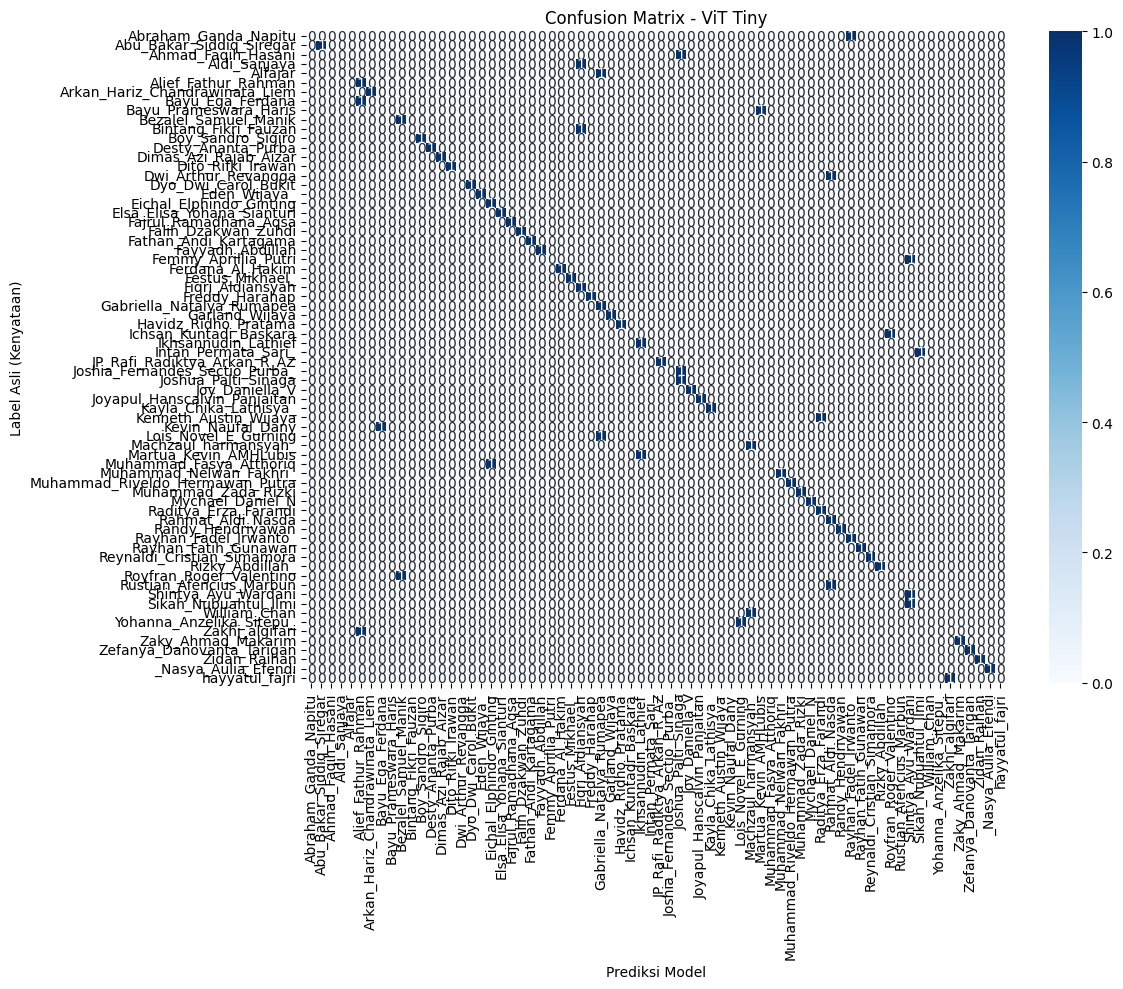

In [18]:
print("\nSedang menghitung Confusion Matrix...")
model.eval() # Gunakan variabel 'model' (bukan trained_model)
arcface_head.eval()
y_true = []
y_pred = []

# Get class names from the full_dataset
class_names = full_dataset.classes

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Panggil ArcFace Head untuk mendapatkan logits
        embeddings = model(images)
        outputs = arcface_head(embeddings) # Gunakan versi TANPA label/margin (evaluasi)

        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# --- TAMPILKAN HASIL ---

# Metrik Keseluruhan
overall_accuracy = accuracy_score(y_true, y_pred)
print(f"\n Overall Validation Accuracy: {overall_accuracy:.2%}")

# Get unique labels present in y_true
unique_labels = np.unique(y_true)
# Filter class_names to only include those present in the validation set
filtered_class_names = [class_names[i] for i in unique_labels]

# Laporan Detail (Precision, Recall, F1-Score)
print("\n Classification Report:")
print(classification_report(y_true, y_pred, labels=unique_labels, target_names=filtered_class_names, zero_division=0))

# Confusion Matrix (Visualisasi)
cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
plt.figure(figsize=(12, 10)) # Increased figure size for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=filtered_class_names, yticklabels=filtered_class_names)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Asli (Kenyataan)')
plt.title('Confusion Matrix - ViT Tiny')
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

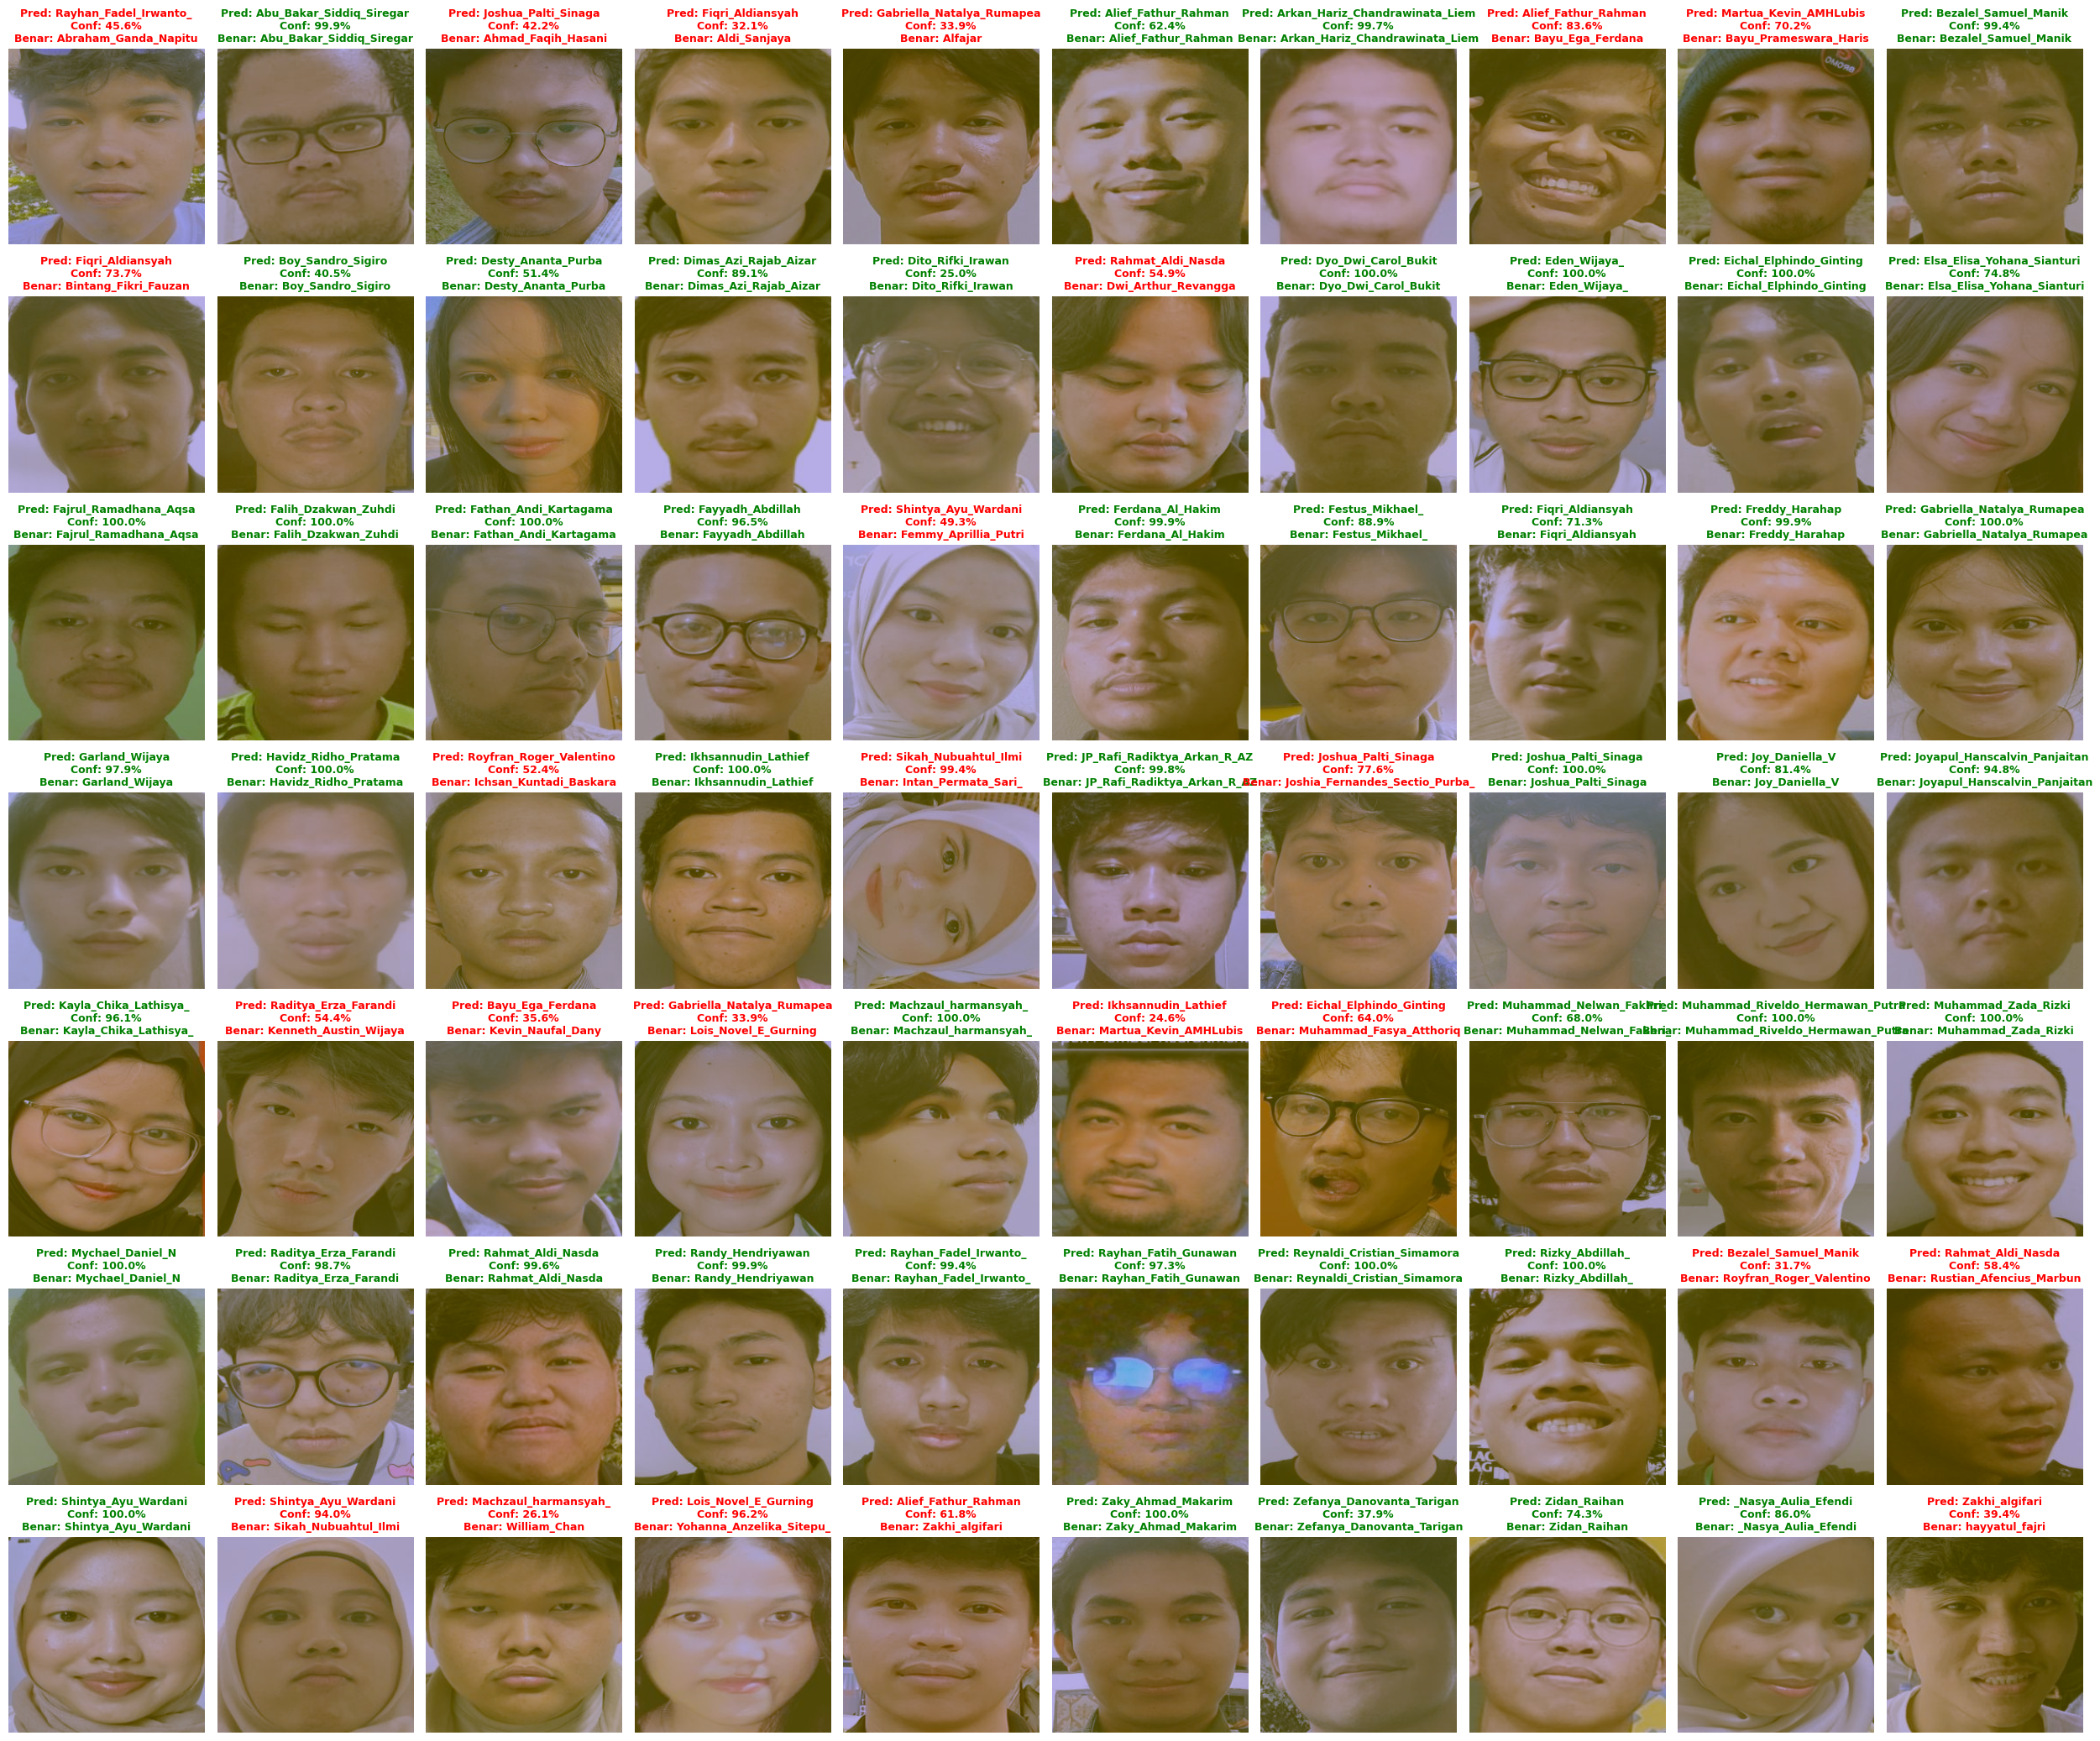

In [19]:
model.eval()
arcface_head.eval()

# Fungsi untuk mendapatkan beberapa gambar dari val_loader
def get_validation_samples(val_loader, class_names, num_samples):
    collected_img_tensors = []
    collected_true_labels_idx = []
    loader_iter = iter(val_loader) # Create an iterator for the loader

    current_samples_count = 0
    while current_samples_count < num_samples:
        try:
            images, labels = next(loader_iter)
            # Take min of remaining needed and current batch size
            to_take = min(num_samples - current_samples_count, images.shape[0])
            collected_img_tensors.append(images[:to_take])
            collected_true_labels_idx.append(labels[:to_take])
            current_samples_count += to_take
        except StopIteration:
            # Ran out of samples in the loader
            print(f"Warning: Only {current_samples_count} samples available, requested {num_samples}.")
            break

    if not collected_img_tensors:
        raise ValueError("No samples could be collected from val_loader.")

    img_tensors = torch.cat(collected_img_tensors).to(device)
    true_labels_idx = torch.cat(collected_true_labels_idx)

    # Convert true_labels_idx to class names
    true_labels = [class_names[label.item()] for label in true_labels_idx]

    # Definisi De-normalisasi (sesuai ViT)
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    # Konversi Tensor ke NumPy untuk ditampilkan (De-normalisasi)
    img_displays = []
    for img_tensor in img_tensors.cpu():
        img_to_show = inv_normalize(img_tensor).permute(1, 2, 0).numpy()
        img_to_show = np.clip(img_to_show, 0, 1) # Klip nilai antara 0 dan 1
        img_displays.append(img_to_show)

    return img_tensors, img_displays, true_labels

# --- PENGATURAN JUMLAH SAMPEL & GRID LAYOUT ---
# Pengaturan Jumlah Sampel yang Ingin Ditampilkan
# Ensure NUM_TO_SHOW does not exceed the total number of validation samples
NUM_TO_SHOW = min(70, len(val_dataset)) # Ensure we don't request more than available

# Atur grid menjadi 7 baris dan 10 kolom (7x10 = 70)
rows = 7
cols = 10

# Dapatkan Sampel Uji
img_inputs, img_displays, true_labels = get_validation_samples(val_loader, class_names, NUM_TO_SHOW)

# Lakukan Prediksi untuk Semua Sampel (ArcFace)
with torch.no_grad():
    # 1. Dapatkan Embeddings dari Body
    embeddings = model(img_inputs)

    # 2. Dapatkan Logits dari ArcFace Head (Tanpa label/margin untuk evaluasi)
    outputs = arcface_head(embeddings)

    # Hitung probabilitas menggunakan Softmax
    probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # Dapatkan probabilitas dan indeks kelas tertinggi untuk semua sampel
    top_p, top_class_indices = probabilities.topk(1, dim=1)

# --- VISUALISASI HASIL DALAM GRID 7x10 ---

# Ukuran figure disesuaikan agar 70 gambar muat
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 3))
axes = axes.flatten()

# The loop should go up to the actual number of collected samples, which is NUM_TO_SHOW
for i in range(NUM_TO_SHOW):
    predicted_label = class_names[top_class_indices[i].item()]
    confidence = top_p[i].item() * 100
    true_label = true_labels[i]

    # Tampilkan Gambar
    axes[i].imshow(img_displays[i])

    # Buat Judul dengan Hasil Prediksi
    color = "green" if predicted_label == true_label else "red"

    title = f"Pred: {predicted_label}\n"
    title += f"Conf: {confidence:.1f}%\n"
    title += f"Benar: {true_label}"

    # Ukuran font dikecilkan (9) agar 3 baris teks muat
    axes[i].set_title(title, fontsize=9, fontweight='bold', color=color)
    axes[i].axis('off') # Sembunyikan sumbu X dan Y

# Sembunyikan subplot yang tidak terpakai
for j in range(NUM_TO_SHOW, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()